<a href="https://colab.research.google.com/github/Eduzc07/machinelearning/blob/master/4_Healthcare/AutomatedDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build an Automated Diagnosis Model

Install Kaggle.

In [0]:
!pip install -q kaggle

Download Kaggle Credentials.

In [8]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Download Datasets from Kaggle.

In [9]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:39<00:00, 42.1MB/s]
100% 2.29G/2.29G [00:39<00:00, 62.9MB/s]
CPU times: user 327 ms, sys: 63.6 ms, total: 391 ms
Wall time: 48 s


Unzip the Data.

In [0]:
from zipfile import ZipFile
with ZipFile("./chest-xray-pneumonia.zip", "r") as f:
    f.extractall(path = "./")

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop

import keras

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

%matplotlib inline

## Data Preparation

In [0]:
#Create variables from the fix Directories
train_dir = "./chest_xray/train/"
valid_dir = "./chest_xray/val/"
test_dir = "./chest_xray/test/"

### Data augmentation 

In [45]:
batch_size = 192

#Create training data generator
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        width_shift_range = 0.1,
        height_shift_range = 0.1) #Create image generator in the abstract

train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size = (150, 150), #what size image we want
        batch_size = batch_size, #how many files to read in at a time
        class_mode = "categorical")

#Create validation test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (150, 150),
        batch_size = 1,
        class_mode = "categorical",
        shuffle = False)

#Create validation data generator
val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = "categorical")

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Display Chest X-Ray Data

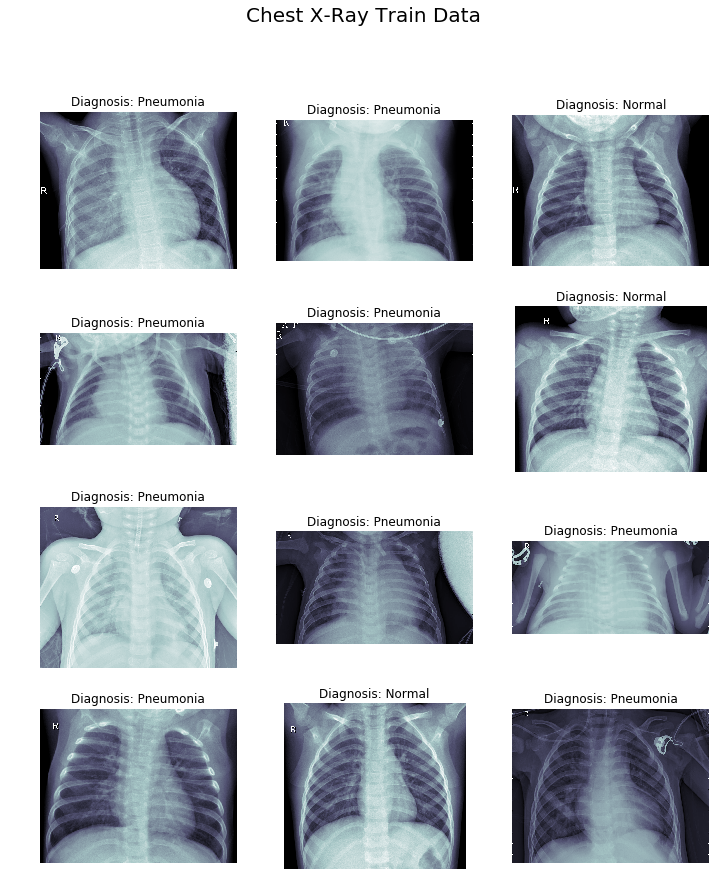

In [21]:
#Generate all predictions
filenames = train_generator.filenames
base_file = train_dir
nb_samples = len(filenames)

rows = 4
cols = 3
size_w = 4
size_h = 3.5

fig, ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle('Chest X-Ray Train Data', fontsize=20)

for idx in range(0, rows*cols):
    i = random.randint(0, nb_samples - 1)
    filename = base_file + filenames[i]

    actual = "Normal" if "NORMAL" in filename else "Pneumonia" 
    tittle = 'Diagnosis: {}'.format(actual)

    img = mpimg.imread(filename)

    ax[idx//cols,idx%cols].imshow(img, cmap='bone')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(tittle)

plt.show()

## Train Model

Create a model using as base InceptionV3.

In [75]:
base_model = InceptionV3(weights = 'imagenet', include_top = False)
base_model.trainable = False  # Freeze the layers not to train

final_model = Sequential([base_model,
                          GlobalAveragePooling2D(),
                          Dense(1024, activation = 'relu'),
                          Dropout(rate = 0.3),
                          Dense(512, activation = 'relu'),
                          Dropout(rate = 0.3),
                          Dense(256, activation = 'relu'),
                          Dropout(rate = 0.3),
                          Dense(128, activation = "relu"),
                          Dropout(rate = 0.3),
                          Dense(64, activation = "relu"),
                          Dropout(rate = 0.3),
                          BatchNormalization(),
                          Dense(2, activation = "softmax")])

final_model.compile(optimizer = 'adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

final_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_32 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)              

In [76]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch = len(train_generator),
        epochs = 20,
        validation_data = val_generator, #validation data generator 
        validation_steps = len(val_generator))

Epoch 1/20
28/28 [==============================] - 103s 4s/step - loss: 0.8427 - acc: 0.5726 - val_loss: 0.7287 - val_acc: 0.5000
Epoch 2/20
28/28 [==============================] - 79s 3s/step - loss: 0.5963 - acc: 0.7286 - val_loss: 2.2295 - val_acc: 0.6250
Epoch 3/20
28/28 [==============================] - 83s 3s/step - loss: 0.3888 - acc: 0.8646 - val_loss: 1.1613 - val_acc: 0.6875
Epoch 4/20
28/28 [==============================] - 83s 3s/step - loss: 0.3020 - acc: 0.8971 - val_loss: 0.9210 - val_acc: 0.6250
Epoch 5/20
28/28 [==============================] - 83s 3s/step - loss: 0.2991 - acc: 0.8939 - val_loss: 1.2717 - val_acc: 0.6875
Epoch 6/20
28/28 [==============================] - 83s 3s/step - loss: 0.2709 - acc: 0.9056 - val_loss: 1.2412 - val_acc: 0.6250
Epoch 7/20
28/28 [==============================] - 83s 3s/step - loss: 0.2755 - acc: 0.9027 - val_loss: 1.7140 - val_acc: 0.6250
Epoch 8/20
28/28 [==============================] - 83s 3s/step - loss: 0.2540 - acc: 0.9

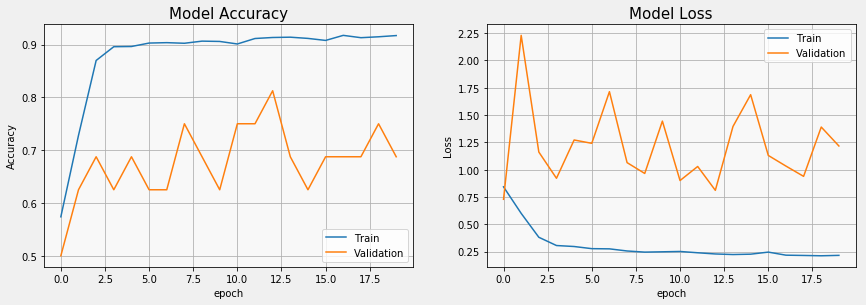

In [77]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10 == 1: # set up the subplots on the first call
    plt.subplots(figsize=(12, 8), facecolor='#F0F0F0')
    plt.tight_layout()

  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model ' + title, fontsize = 15)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['Train', 'Validation'])
  ax.grid(True)

display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'Accuracy', 221)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'Loss', 222)

In [78]:
result = final_model.evaluate_generator(test_generator,
                                         steps = len(test_generator))
print('Loss: %.2f'% result[0])
print('Accuracy: %.3f %%'% (result[1]*100))

Loss: 0.92
Accuracy: 72.917 %


In [79]:
vl_score = final_model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.71      0.47      0.56       234
   Pneumonia       0.73      0.89      0.80       390

    accuracy                           0.73       624
   macro avg       0.72      0.68      0.68       624
weighted avg       0.73      0.73      0.71       624

AUC:  0.6764957264957265


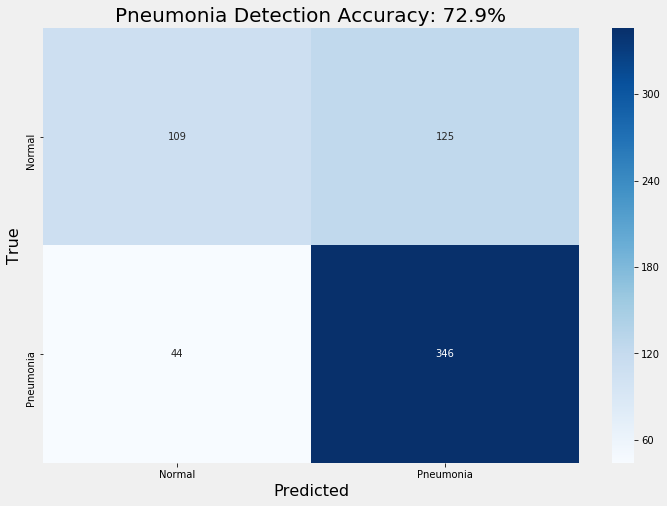

In [80]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12, 8), facecolor='#F0F0F0')
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')

plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc), fontsize = 20)
plt.ylabel('True', fontsize = 16)
plt.xlabel('Predicted', fontsize = 16)
plt.show()

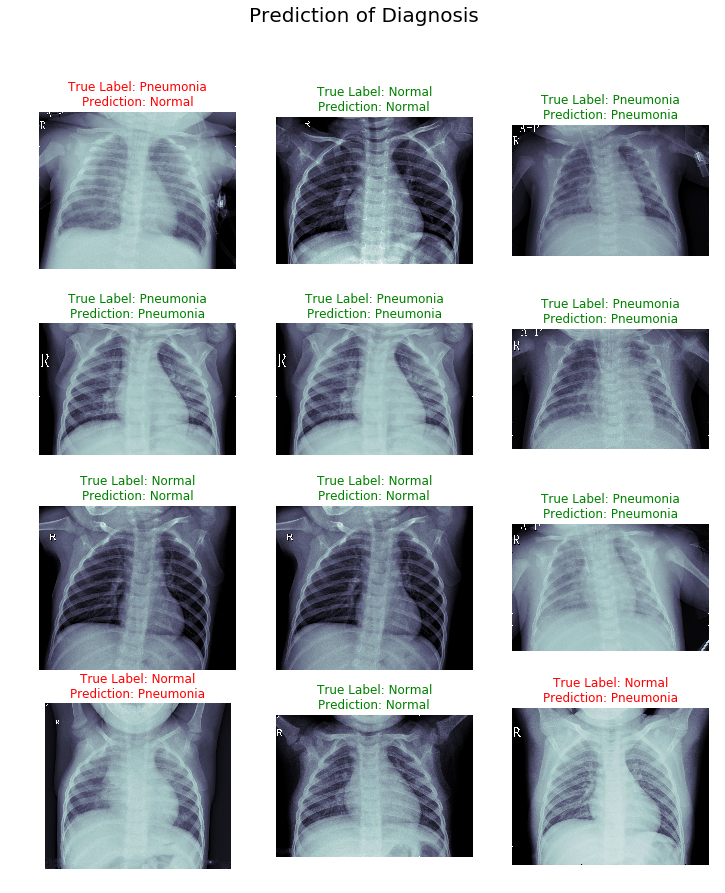

In [82]:
#Generate predictions from Validation Sets
filenames = val_generator.filenames
base_file = valid_dir
nb_samples = len(filenames)

label_CM = {0: 'red',  # Incorrect diagnosis
            1: 'green' # Correct diagnosis
            }

rows = 4
cols = 3
size_w = 4
size_h = 3.5

fig, ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle('Prediction of Diagnosis', fontsize = 20)

for idx in range(0, rows*cols):
    i = random.randint(0, nb_samples - 1)
    filename = base_file + filenames[i]

    img = image.load_img(filename, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Run Prediction
    y = final_model.predict(x)

    actual = "Normal" if "NORMAL" in filename else "Pneumonia" 
    predicton = "Normal" if (y.argmax(axis=-1)==0) else "Pneumonia"
    score = 1 if (actual == predicton) else 0

    title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))

    img = mpimg.imread(filename)

    ax[idx//cols,idx%cols].imshow(img, cmap='bone')
    # extent = 0, 1, 0, 1
    # ax[idx//cols,idx%cols].imshow(im_data, cmap='gray_r', extent=extent)
    # ax[idx//cols,idx%cols].imshow(attn_img, cmap='magma', vmin=0, vmax=1,
    #                               extent=extent, alpha=0.5,
    #                               interpolation='lanczos')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(title_text, color=label_CM[score])

plt.show()

## Sources

[1] [Pneumonia_detection_multi_vgg](https://github.com/iRyanBell/chest_xray_pneumonia_vgg_attn_ensemble/blob/master/pneumonia_detection_multi_vgg.ipynb)

[2] [Transfer_Learning_Xray_Pneumonia](https://github.com/mannybernabe/transferLearning_pneumonia/blob/master/Transfer_Learning_Xray_Pneumonia.ipynb)

[3] [Detection of Ppneumonia](https://colab.research.google.com/gist/JayThibs/73a58e51326f1fb548b09df94166a3ca/detection-of-pneumonia-from-chest-x-ray-images-1-0-0-0.ipynb#scrollTo=-aGOUzQM88Ci)